In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np

import darkhistory.physics as phys

import main_dm_baryon_scattering as main

from tqdm import tqdm_notebook as tqdm

import pickle

In [4]:
%autoreload
import config
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

decay_elec_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

def xsec_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def xsec_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]

In [5]:
struct_boost = phys.struct_boost_func(model='einasto_subs')
struct_boost_NFW = phys.struct_boost_func(model='NFW_no_subs')
struct_boost_pwave = phys.struct_boost_func(model='pwave_NFW_no_subs')

# Improved f_exc

In [31]:
mDM=1e6
lifetime=3e25
sigmav=3e-26
datums = main.evolve(
    DM_process='decay', mDM=mDM, primary='phot_delta',
    start_rs = 3000, sigmav=sigmav, lifetime=lifetime,
    coarsen_factor=4, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.01
)
eleceng = datums['lowengelec'].eng

In [17]:
import darkhistory.low_energy.lowE_electrons as lowE_elec
import darkhistory.low_energy.lowE_photons as lowE_phot
import darkhistory.low_energy.lowE_deposition as lowE
MEDEA_interp = lowE_elec.make_interpolator()

In [18]:
rs_list = datums['rs']
eleceng = datums['lowengelec'].eng
# elec_exc = [lowE_elec.compute_fs(MEDEA_interp, 
#            datums['lowengelec'][i], 
#            datums['x'][i,0], 
#            phys.inj_rate('pwave', rs_list[i], mDM=1e8, sigmav=3e-24), 
#            4*.001/phys.hubble(rs_list[i]))[2]
#  for i in np.arange(len(rs_list))]

phot_exc = [lowE_phot.compute_fs( 
           datums['lowengphot'][i],
           np.array([
                1. - phys.xHII_std(rs_list[i]),
                phys.chi - phys.xHeII_std(rs_list[i]),
                phys.xHeII_std(rs_list[i])
            ]), 
           phys.inj_rate('decay', rs_list[i], mDM=mDM, sigmav=sigmav, lifetime=lifetime), 
           4*.001/phys.hubble(rs_list[i]), method='old')[2]
 for i in np.arange(len(rs_list))]

# tot_exc = [lowE.compute_fs(MEDEA_interp, 
#            datums['lowengelec'][i], 
#            datums['lowengphot'][i], 
#            np.array([
#                 1. - phys.xHII_std(rs_list[i]),
#                 phys.chi - phys.xHeII_std(rs_list[i]),
#                 phys.xHeII_std(rs_list[i])
#             ]), 
#            phys.inj_rate('pwave', rs_list[i], mDM=1e9, sigmav=3e-24), 
#            4*.001/phys.hubble(rs_list[i]), 
#            [0,0,0,0,0], cmbloss=0, 
#            method='no_He', 
#            separate_higheng=True, 
#            cross_check=False)[0][2]
# for i in np.arange(len(rs_list))]

# tot_exc = [lowE.compute_fs(MEDEA_interp, 
#            datums['lowengelec'][i], 
#            datums['x'][i,0], 
#            phys.inj_rate('pwave', rs_list[i], mDM=1e8, sigmav=3e-24), 
#            4*.001/phys.hubble(rs_list[i]))[2]
#  for i in np.arange(len(rs_list))]

In [19]:
fexc = datums['f']['low']['exc']+0*datums['f']['high']['exc']
rs_list = datums['lowengphot'].rs
nrms = phys.nB * rs_list**3 / (4*.001/phys.hubble(rs_list)) /(
    phys.inj_rate('decay', rs_list, mDM=mDM, sigmav=sigmav, lifetime=lifetime)
)
fexc2 = datums['lowengphot'].toteng(bound_type='eng',
                            bound_arr=np.array([phys.lya_eng,phys.rydberg])
                           )*nrms

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


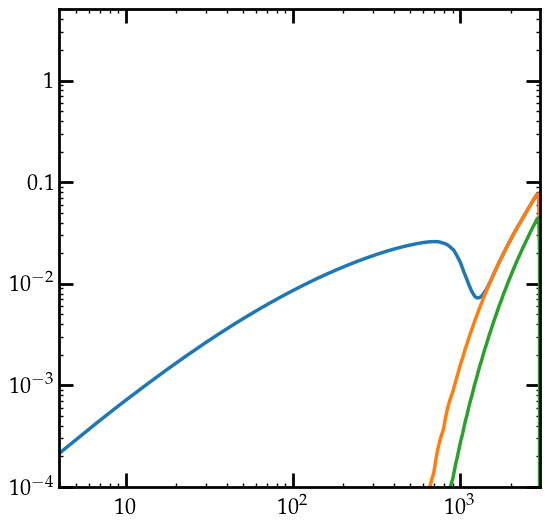

In [20]:
plt.figure()
ax = plt.gca()
plt.axis([4,3e3,1e-4,5])
ax.loglog()
plt.plot(rs_list,fexc)
plt.plot(rs_list,fexc2[0])
# plt.plot(rs_list,phys.f_std(1e9,rs_list,'phot','pwave',True,'exc'))
# plt.plot(rs_list,fexc2[0]+elec_exc)
# plt.plot(rs_list,tot_exc)
plt.plot(rs_list,phot_exc)

# Improved lowengelec

In [32]:
%autoreload
eleceng = datums['lowengelec'].eng

phys.coll_ion_sec_elec_spec(30, eleceng, species='HI', method='MEDEA')

array([0.01343936, 0.01408025, 0.01474235, 0.01542538, 0.01612895,
       0.01685255, 0.01759555, 0.01835719, 0.01913658, 0.01993272,
       0.02074446, 0.02157057, 0.02240971, 0.02326046, 0.02412136,
       0.02499094, 0.02586772, 0.02675035, 0.02763759, 0.02852842,
       0.02942216, 0.03031854, 0.03121786, 0.03212115, 0.03303035,
       0.03394855, 0.03488027, 0.03583179, 0.03681155, 0.03783066,
       0.03890355, 0.04004871, 0.0412897 , 0.04265646, 0.04418694,
       0.06100549, 0.0494248 , 0.05144779, 0.06086333, 0.0625759 ,
       0.07473165, 0.08184835, 0.09367566, 0.11152604, 0.13146209,
       0.16028485, 0.10647647, 0.00060689, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [11]:
import csv
HI_ionization_data = []
with open('/Users/gregoryridgway/Desktop/HI_ionization.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        HI_ionization_data.append([float(row[0]),float(row[1])])
HI_ionization_data = np.array(HI_ionization_data)

HeI_ionization_data = []
with open('/Users/gregoryridgway/Desktop/HeI_ionization.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        HeI_ionization_data.append([float(row[0]),float(row[1])])
HeI_ionization_data = np.array(HeI_ionization_data)

HeII_ionization_data = []
with open('/Users/gregoryridgway/Desktop/HeII_ionization.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        HeII_ionization_data.append([float(row[0]),float(row[1])])
HeII_ionization_data = np.array(HeII_ionization_data)

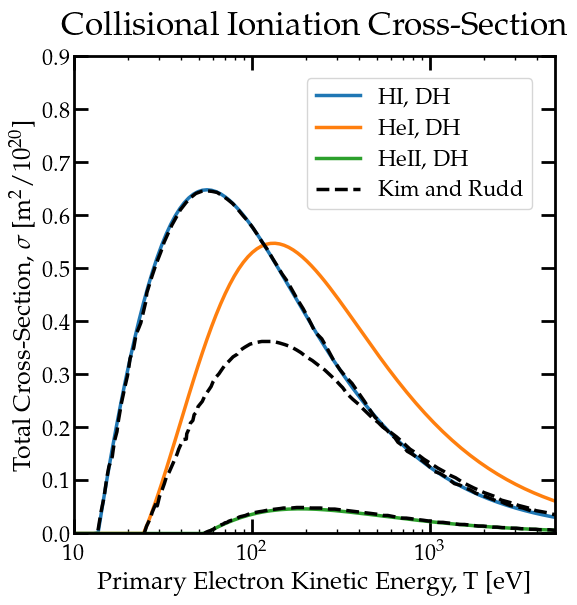

In [56]:
%autoreload
plt.figure()
plt.xscale('log')
plt.axis([10,5e3,0,.9])

plt_HI, = plt.plot(eleceng, 
         phys.coll_ion_xsec(eleceng, species='HI', method='MEDEA')*1e16, label = r'HI, DH')

plt_HeI, = plt.plot(eleceng, 
         phys.coll_ion_xsec(eleceng, species='HeI', method='MEDEA')*1e16, label = r'HeI, DH')
plt_HeII, = plt.plot(eleceng, 
         phys.coll_ion_xsec(eleceng, species='HeII', method='MEDEA')*1e16, label = r'HeII, DH')

plt_KimHI, = plt.plot(HI_ionization_data[:,0],HI_ionization_data[:,1], linestyle='--', color='k', label=r'Kim and Rudd')
plt_KimHeI, = plt.plot(HeI_ionization_data[:,0],HeI_ionization_data[:,1], linestyle='--', color='k', label=r'HeI, Kim and Rudd')
plt_KimHeII, = plt.plot(HeII_ionization_data[:,0],HeII_ionization_data[:,1], linestyle='--', color='k', label=r'HeII, Kim and Rudd')



plt.title(r'Collisional Ioniation Cross-Section')
plt.xlabel(r'Primary Electron Kinetic Energy, T [eV]')
plt.ylabel(r'Total Cross-Section, $\sigma$ [m$^2/10^{20}$]')

plt.legend(handles = [plt_HI, plt_HeI, plt_HeII, plt_KimHI])

In [90]:
exc_data=np.resize(
    np.loadtxt('/Users/gregoryridgway/Desktop/Hydrogen_excitation_np.txt'),
    (10,58))

exc_data = np.transpose(np.append(np.array([np.zeros(10)]),np.transpose(exc_data),axis=0))
exc_data[0,0] = phys.lya_eng

In [139]:
pickle.dump(exc_data2,open('/Users/gregoryridgway/Downloads/dataverse_files_06_08_2019/exc_xsec_data.p','wb'))

In [12]:
Kim_exc_data = []
with open('/Users/gregoryridgway/Desktop/exc_2p.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        Kim_exc_data.append([float(row[0]),float(row[1])])
Kim_exc_data = np.array(Kim_exc_data)

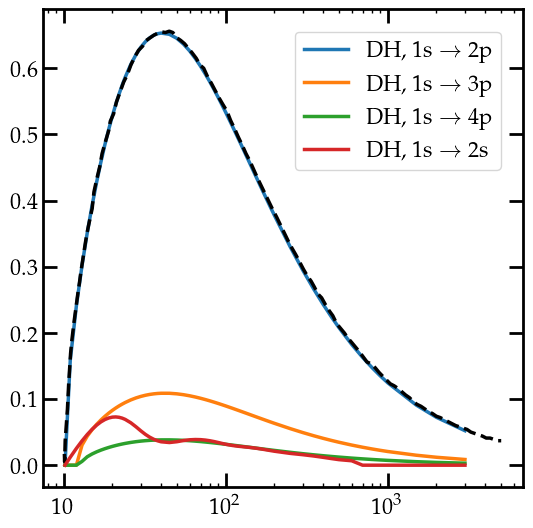

In [135]:
plt.figure()
plt.xscale('log')
# plt.axis([10,3000,0,.1])
plt.plot(exc_data[0],exc_data[1],label=r'DH, 1s $\to$ 2p')
plt.plot(Kim_exc_data[:,0],Kim_exc_data[:,1],linestyle='--',color='k')
plt.plot(exc_data[0],exc_data[2],label=r'DH, 1s $\to$ 3p')
plt.plot(exc_data[0],exc_data[3],label=r'DH, 1s $\to$ 4p')
plt.plot(exc_data[0],int_2s(exc_data[0]),label=r'DH, 1s $\to$ 2s')

plt.legend()

In [151]:
config.glob_exc_data

In [9]:
%autoreload
phys.coll_exc_xsec(20, species='2p', method = 'MEDEA')

5.2779e-17

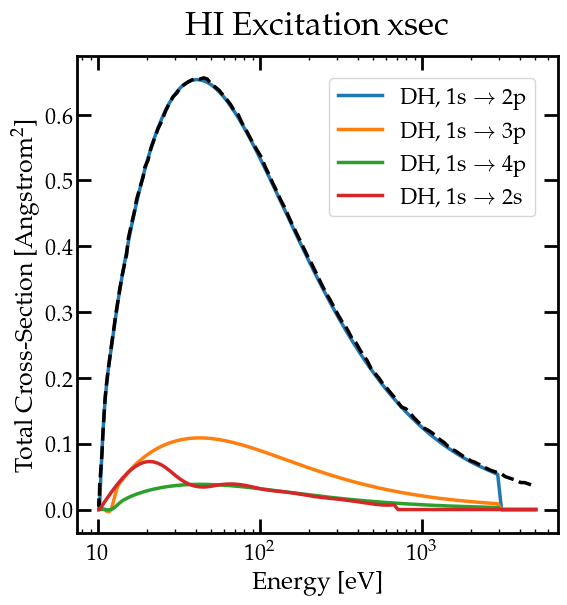

In [17]:
plt.figure()
plt.xscale('log')
# plt.axis([10,3000,0,.1])
plt.title(r'HI Excitation xsec')
plt.xlabel(r'Energy [eV]')
plt.ylabel(r'Total Cross-Section [Angstrom$^2$]')
eng = Kim_exc_data[:,0]
plt.plot(eng,phys.coll_exc_xsec(eng, species='2p', method = 'MEDEA')*1e16,label=r'DH, 1s $\to$ 2p')
plt.plot(eng,Kim_exc_data[:,1],linestyle='--',color='k')
plt.plot(eng,phys.coll_exc_xsec(eng, species='3p', method = 'MEDEA')*1e16,label=r'DH, 1s $\to$ 3p')
plt.plot(eng,phys.coll_exc_xsec(eng, species='4p', method = 'MEDEA')*1e16,label=r'DH, 1s $\to$ 4p')
plt.plot(eng,phys.coll_exc_xsec(eng, species='2s', method = 'MEDEA')*1e16,label=r'DH, 1s $\to$ 2s')

plt.legend()

In [ ]:
plt.figure()
ax = plt.gca()
ax.loglog()

plt.axis([1e-3,3e6,1e-27,500])
plt.xlabel(r'Energy [eV]')
plt.ylabel(r'Photon Spectrum $dN/dE$ [per baryon]')
for ind in [-10, -101, 0]:
    plt.plot(soln_decay['highengphot'][ind].eng,
             soln_decay['highengphot'][ind].dNdE, label=r'z='+str(int(soln_decay['rs'][ind])))
    
# Text
plt.title(r'$\chi \to e^+ e^-$, Photon Spectrum')
interval = .08
# plt.text(0.09, 0.93, r'$\chi \to e^+ e^-$', fontsize=20, transform=ax.transAxes) 
plt.text(0.62, 0.93-0*interval-.02, r'$m_\chi$ = 3 MeV', fontsize=20, transform=ax.transAxes) 
# # plt.text(0.06, 0.88-interval*2-.02, r'$\langle \sigma v \rangle$ = $10^{-29}$ cm$^3$s$^{-1}$', fontsize=20, transform=ax.transAxes) 
plt.text(0.62, 0.93-interval*2/2-.02, r'$\tau$ = $8 \times 10^{25}$ s', fontsize=20, transform=ax.transAxes)
# plt.axvline(1.5e6)

plt.legend(loc=(.62,.57))
plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/spectra.pdf')
plt.show()